In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# import profile data

infile = r'../OOI Biogeochemical Sensor Data Working Group/DATA_FILES_FOR_FIGURES/bio-optics/BioOpticsSource/BO_F6_1_26_JUN_2018_Noon_Profile.csv'
prof = pd.read_csv(infile)

# import bottle data
infile = r'../OOI Biogeochemical Sensor Data Working Group/DATA_FILES_FOR_FIGURES/bio-optics/BioOpticsSource/BO_F6_8_26_JUN_2018_cast_CTD002_Discrete_and_CTD_data.csv'
bot = pd.read_csv(infile)

bot = bot[bot['Discrete Chlorophyll [ug/L]']>0]

# only select the upcast data
idx = prof.index[prof.depth == np.min(prof.depth)]
idx = idx[0].astype('int')

prof_up = prof.iloc[:idx]

prof_up = prof_up.sort_values(by = 'depth')
bot = bot.sort_values(by = 'CTD Depth [m]')

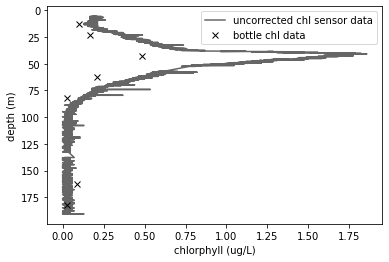

In [4]:
# plot chl sensor and bottle data

plt.plot(prof_up['chlora'], prof_up['depth'],'-k', alpha = 0.6, label = 'uncorrected chl sensor data')
plt.plot(bot['Discrete Chlorophyll [ug/L]'], bot['CTD Depth [m]'], 'xk', label = 'bottle chl data')

ax = plt.gca()
ax.invert_yaxis()

plt.xlabel('chlorophyll (ug/L)')
plt.ylabel('depth (m)')

plt.legend()
plt.show()

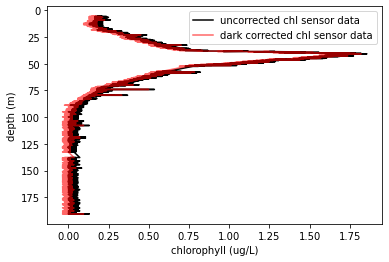

In [5]:
# apply the dark correction

# find the minimum chl value in teh cast
min_chl = prof_up[(prof_up['depth'] > 150)].chlora.median()

prof_up['chlora_dark'] = prof_up['chlora'] - min_chl

# plot chl sensor and dark corrected data

plt.plot(prof_up['chlora'], prof_up['depth'],'-k',label = 'uncorrected chl sensor data')
plt.plot(prof_up['chlora_dark'], prof_up['depth'],'-r', alpha = 0.6, label = 'dark corrected chl sensor data')


ax = plt.gca()
ax.invert_yaxis()

plt.xlabel('chlorophyll (ug/L)')
plt.ylabel('depth (m)')
plt.legend()

plt.show()


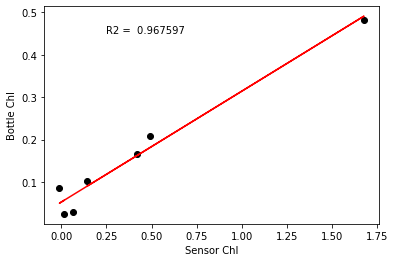

In [7]:
# line up bottle data to sensor
prof_match = np.interp(bot['CTD Depth [m]'], prof_up.depth, prof_up.chlora_dark)

# plt.plot(bot['Discrete Chlorophyll [ug/L]'], bot['CTD Depth [m]'], 'og')
plt.plot(prof_match, bot['Discrete Chlorophyll [ug/L]'], 'ok')
plt.xlabel('Sensor Chl')
plt.ylabel('Bottle Chl')

# regression between bottle and sensor data
from scipy import stats
x = prof_match
y = bot['Discrete Chlorophyll [ug/L]']

res = stats.linregress(x, y)

plt.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')
plt.text(0.25, 0.45, f"R2 =  {res.rvalue**2:.6f}")
plt.show()

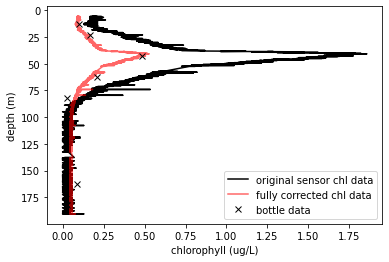

In [8]:
# apply slope and offset cprrection to sensor data

prof_up['chlora_corr'] = res.intercept + res.slope*prof_up['chlora_dark']

# plot chl sensor and corrected data

plt.plot(prof_up['chlora'], prof_up['depth'],'-k', label = 'original sensor chl data')
plt.plot(prof_up['chlora_corr'], prof_up['depth'],'-r', alpha = 0.6, label = 'fully corrected chl data')
plt.plot(bot['Discrete Chlorophyll [ug/L]'], bot['CTD Depth [m]'], 'xk', label = 'bottle data')

plt.legend()

ax = plt.gca()
ax.invert_yaxis()

plt.xlabel('chlorophyll (ug/L)')
plt.ylabel('depth (m)')

plt.show()